# Collect data

In [31]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import os

# --- 설정값 ---
TOTAL_STEPS = 20000
ENV_ID = 'LunarLander-v3'

print(f"'{ENV_ID}' 환경에서 총 {TOTAL_STEPS} 스텝의 데이터를 수집합니다.")

# --- 환경 초기화 ---
env = gym.make(ENV_ID, render_mode='rgb_array')

# --- 데이터 버퍼 ---
obs_buffer = []
frame_buffer = []
action_buffer = []
reward_buffer = []
terminated_buffer = []
truncated_buffer = []

observation, info = env.reset()

for _ in tqdm(range(TOTAL_STEPS)):
    action = env.action_space.sample()
    next_observation, reward, terminated, truncated, info = env.step(action)
    
    # 버퍼에 저장
    obs_buffer.append(observation)  # 상태 (벡터)
    frame = env.render()            # 프레임 이미지
    frame_buffer.append(frame)     # 이미지 추가

    action_buffer.append(action)
    reward_buffer.append(reward)
    terminated_buffer.append(terminated)
    truncated_buffer.append(truncated)

    if terminated or truncated:
        observation, info = env.reset()
    else:
        observation = next_observation

env.close()

print(f"\n데이터 수집 완료! 총 {len(obs_buffer)}개의 경험을 저장했습니다.")

# --- 저장 디렉토리 만들기 ---
os.makedirs("data", exist_ok=True)

# --- 저장 ---
np.savez_compressed(
    f"data/{ENV_ID}_with_frames.npz",
    observations=np.array(obs_buffer, dtype=np.float32),  # (100000, 8)
    frames=np.array(frame_buffer, dtype=np.uint8),        # (100000, H, W, 3)
    actions=np.array(action_buffer, dtype=np.int8),
    rewards=np.array(reward_buffer, dtype=np.float32),
    terminateds=np.array(terminated_buffer, dtype=np.bool_),
    truncateds=np.array(truncated_buffer, dtype=np.bool_)
)

print(f"✅ '{ENV_ID}_with_frames.npz' 파일로 프레임 포함 데이터 저장 완료!")

'LunarLander-v3' 환경에서 총 20000 스텝의 데이터를 수집합니다.


  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:24<00:00, 828.65it/s]



데이터 수집 완료! 총 20000개의 경험을 저장했습니다.
✅ 'LunarLander-v3_with_frames.npz' 파일로 프레임 포함 데이터 저장 완료!


In [33]:
data = np.load('data/LunarLander-v3.npz')

In [6]:
import numpy as np
data = np.load('data/LunarLander-v3.npz')
observations_raw = data['frames']
actions = data['actions']
rewards = data['rewards']

# VAE train

In [2]:
import torch
from torch.utils.data import DataLoader
from torch import optim
from PIL import Image
from torchvision import transforms
from parts.VAE_CNN import VAE, vae_loss_function, CustomImageDataset
from parts.MDN_RNN import MDN_RNN, mdn_rnn_loss
from parts.controller import controller
from tqdm.notebook import tqdm

observations = torch.tensor(observations_raw).permute(0, 3, 1, 2)
vae = VAE(input_channel=3, latent_dim=256).to('cuda:0')

resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()]) 

observations = CustomImageDataset(data=observations, transform=resize)

dataloader = DataLoader(dataset=observations, batch_size=512)

optimizer = optim.AdamW(vae.parameters(), lr=1e-4)

def vae_train(vae, optimizer, dataloader, epochs=10):
    vae.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, data in enumerate(tqdm(dataloader)):
            data = data.to('cuda:0')
            _, recon_image, mu, logvar = vae(data)

            loss = vae_loss_function(recon_image, data, mu, logvar, beta=1)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
        
        print(f'Epoch {epoch}, Everage loss: {total_loss/len(dataloader):.6f}')

vae_train(vae, optimizer, dataloader, epochs=10)


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0, Everage loss: 8426.898022


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1, Everage loss: 8384.134326


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2, Everage loss: 7448.568640


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3, Everage loss: 5147.609106


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4, Everage loss: 3414.598822


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5, Everage loss: 2500.204724


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6, Everage loss: 2063.136441


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7, Everage loss: 1839.242599


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8, Everage loss: 1705.831250


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9, Everage loss: 1620.347833


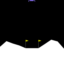

In [3]:
to_pil = transforms.ToPILImage()
to_pil(observations[0])

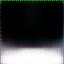

In [13]:
# latent_size 256, beta=0.2
vae.eval()
data = observations[4222].unsqueeze(0).to("cuda:0")
hidden_state, recon_image, _, _ = vae(data)
to_pil(recon_image[0])

In [14]:
torch.save(vae.state_dict(), 'model_weights/vae_weights.pth')

# MDN_RNN train

In [ ]:
import torch
from parts.VAE_CNN import VAE
vae = VAE(input_channel=3, latent_dim=256).to('cuda:0')
vae.load_state_dict(torch.load('model_weights/vae_weights.pth'))
vae.eval()
import numpy as np
data = np.load('data/montezuma_data1.npz')
observations_raw = data['observations']
actions = data['actions']
rewards = data['rewards']

In [ ]:
from torchvision import transforms

observations = torch.tensor(observations_raw).permute(0, 3, 1, 2)

resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()]) 

import torch
from parts.VAE_CNN import VAE
vae = VAE(input_channel=3, latent_dim=256).to('cuda:0')
vae.load_state_dict(torch.load('model_weights/vae_weights.pth'))
vae.eval()

import numpy as np
data = np.load('data/montezuma_data1.npz')
observations_raw = data['observations']
actions = data['actions']

VAE(
  (encode_cnn): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): SiLU()
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): SiLU()
    (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): SiLU()
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): SiLU()
  )
  (mu_linear): Linear(in_features=1024, out_features=256, bias=True)
  (var_linear): Linear(in_features=1024, out_features=256, bias=True)
  (decode_linear): Linear(in_features=256, out_features=1024, bias=True)
  (decode_cnn): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): SiLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): SiLU()
    (4): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): SiLU()
    (6): ConvTranspose2d(8, 3, kernel_size=(4, 4), stride=(2, 2

In [3]:
import torch
from torch.utils.data import DataLoader
from torch import optim
from PIL import Image
from tqdm.notebook import tqdm
from parts.MDN_RNN import MDN_RNN, mdn_rnn_loss, SequenceDataset
import numpy as np

action_size = int(actions.max()) + 1
action_onehot = np.eye(action_size)[actions] # np.eye is generates identity matrix

mdn_rnn = MDN_RNN(input_size=256, action_size=action_size).to('cuda:0')

seq_dataset = SequenceDataset(image_dataset=observations, transforms=resize, action_dataset=action_onehot, sequence_length=1000)
dataloader = DataLoader(dataset=seq_dataset, batch_size=48, num_workers=16)

optimizer = optim.AdamW(mdn_rnn.parameters(), lr=1e-4)

def rnn_train(model=mdn_rnn, dataloader=dataloader, optimizer=optimizer, epochs=10):
    model.train()
    vae.eval()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (image, action) in enumerate(tqdm(dataloader, desc=f'epoch: {epoch+1}')):
            image, action = image.to('cuda:0'), action.to('cuda:0')
            with torch.no_grad():
                # have to reshape image vector because vae(cnn) input shape is (batch_size, channel_size, height, width)
                batch, sequence, C, H, W = image.size()
                reshape_images = image.view(-1, C, H, W)
                z_vectors_flatten, _, _, _ = vae(reshape_images)
                z_vectors = z_vectors_flatten.view(batch, sequence, -1)
                
            mu, sigma, phi = model(z_vectors, action)

            batch, sequence, num_dist, latent_size = mu.size()

            mu_pred = mu[: , :-1, :].reshape(-1, num_dist, latent_size)
            sigma_pred = sigma[: , :-1, :].reshape(-1, num_dist, latent_size)
            phi_pred = phi[: , :-1, :].reshape(-1, num_dist)
            target_z =  z_vectors[: , 1:, :].reshape(-1, latent_size)

            loss = mdn_rnn_loss(mu_pred, sigma_pred, phi_pred, target_z)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            if (batch_idx + 1) % 100 == 0:
                print(f"loss {total_loss / (batch_idx + 1)}")

        print(f"epoch: {epoch+1}, Everage loss: {total_loss/len(dataloader):.6f}")

rnn_train()

epoch: 1:   0%|          | 0/396 [00:00<?, ?it/s]

KeyboardInterrupt: 

# RNN test

In [1]:
import numpy as np
data = np.load('data/LunarLander-v3.npz')
observations_raw = data['frames']
actions = data['actions']
rewards = data['rewards']

In [8]:
import torch
from parts.VAE_CNN import VAE, vae_loss_function, CustomImageDataset
from parts.MDN_RNN import MDN_RNN, mdn_rnn_loss, sampling, SequenceDataset
from parts.controller import controller

action_size = int(actions.max()) + 1
action_onehot = np.eye(action_size)[actions] # np.eye is generates identity matrix

vae = VAE(input_channel=3, latent_dim=256).to('cuda:0')
mdn_rnn = MDN_RNN(input_size=256, action_size=action_size).to('cuda:0')
controller = controller(action_size=action_size, h_vector_size=256, z_vector_size=256, hidden_size=256)

vae.load_state_dict(torch.load('model_weights/vae_weights.pth'))
mdn_rnn.load_state_dict(torch.load('model_weights/mdnrnn_weights.pth'))


<All keys matched successfully>

In [6]:
from torchvision import transforms

observations = torch.tensor(observations_raw).permute(0, 3, 1, 2)

resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()]) 


seq_dataset = SequenceDataset(image_dataset=observations, transforms=resize, action_dataset=action_onehot, reward_dataset=rewards, sequence_length=1000)

In [9]:
vae.eval()
mdn_rnn.eval()
z_vectors, _, _, _  = vae(seq_dataset[0][0].to('cuda:0'))
z_vectors = z_vectors.unsqueeze(0)
action_first = seq_dataset[0][1].to('cuda:0')
action_first = action_first.unsqueeze(0)

mu, sigma, phi, reward, h = mdn_rnn(z_vectors, action_first)

In [11]:
p = phi[:, -1, :]
m = mu[:, -1, :, :]
s = sigma[:, -1, :, :]

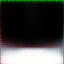

In [12]:
from torch import distributions
from torchvision import transforms

mixture_distribution = distributions.Categorical(probs=p)
component_distribution = distributions.Normal(loc=m, scale=s)
component_dist = distributions.Independent(
    component_distribution,
    reinterpreted_batch_ndims=1
)
mixture_gaussian = distributions.MixtureSameFamily(mixture_distribution, component_dist)
vector = mixture_gaussian.sample()

to_pil = transforms.ToPILImage()
a = vae.decode(vector)
to_pil(a[0])

# Controller train

In [1]:
import numpy as np
from parts.MDN_RNN import MDN_RNN, sampling
from parts.controller import controller, choice_control
from parts.VAE_CNN import VAE
import torch

data = np.load('data/LunarLander-v3.npz')

actions = data['actions']
action_size = int(actions.max()) + 1

images = data['frames']

mdn_rnn = MDN_RNN(input_size=256, action_size=action_size).to('cuda:0')
mdn_rnn.load_state_dict(torch.load('model_weights/mdnrnn_weights.pth'))

vae = VAE(input_channel=3, latent_dim=256).to('cuda:0')
vae.load_state_dict(torch.load('model_weights/vae_weights.pth'))
vae.eval()
print()

In [2]:
import torch 
from torchvision import transforms

resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()]) 

image = images[0]
image_tensor = torch.tensor(image).permute(2, 0, 1)

resized_image = torch.tensor(resize(image_tensor)).unsqueeze(0).to('cuda:0')

z_vector, _ ,_ ,_ = vae(resized_image)

/tmp/ipykernel_106667/1765552956.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resized_image = torch.tensor(resize(image_tensor)).unsqueeze(0).to('cuda:0')


In [3]:
action = actions[0]
action_onehot = np.eye(action_size)[action]
action_onehot_tensor = torch.tensor(action_onehot).unsqueeze(0).unsqueeze(0).to(torch.float32).to('cuda:0')

z_vector_rnn = z_vector.unsqueeze(0)

mu, sigma, phi, _, h_vector, (h_n, c_n) = mdn_rnn(z_vector_rnn, action_onehot_tensor)

In [4]:
from parts.controller import controller, choice_control

C = controller(action_size=action_size, z_vector_size=256, h_vector_size=256, hidden_size=256).to('cuda:0')

In [6]:
controller_train(1000, C, optimizer, z_vector, h_vector, (h_n, c_n))

-2246.1904296875

In [5]:
from parts.MDN_RNN import MDN_RNN, sampling
from parts.controller import controller, choice_control
import torch

C = controller(action_size=action_size, z_vector_size=256, h_vector_size=256, hidden_size=256).to('cuda:0')

optimizer = torch.optim.AdamW(C.parameters(), lr=1e-4)

def controller_train(steps, controller, optimizer, initial_z, initial_h, cell):
    controller.train()
    mdn_rnn.train()

    rewards = []
    z = initial_z.to('cuda:0')
    h = initial_h.to('cuda:0')

    z_rnn = z.unsqueeze(0)

    for _ in range(steps):
        action_prob = controller(z, h)
        action = choice_control(action_prob)
        action_onehot = np.eye(action_size)[action]
        action_onehot_tensor = torch.tensor(action_onehot).unsqueeze(0).unsqueeze(0).to(torch.float32).to('cuda:0')

        mu, sigma, phi, reward, h, (h_n, c_n) = mdn_rnn(z_rnn, action_onehot_tensor, cell)
        cell = (h_n, c_n)

        z_rnn = sampling(mu, sigma, phi) 
        z = z_rnn.squeeze(0)

        rewards.append(reward)


    total_imagined_reward = torch.stack(rewards).sum()
    loss = -total_imagined_reward

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return total_imagined_reward.item()